In [1]:
import os
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

In [2]:
afdb_feature_filenames = os.listdir("./../extract_features/AFDB/")
ltafdb_feature_filenames = os.listdir("./../extract_features/LTAFDB/")

base_pos = np.empty((0, 57))

for feature in afdb_feature_filenames:
    sample = np.load(f"./../extract_features/AFDB/{feature}", allow_pickle=True)
    base_pos = np.vstack((base_pos, sample))

for feature in ltafdb_feature_filenames:
    sample = np.load(f"./../extract_features/LTAFDB/{feature}", allow_pickle=True)
    base_pos = np.vstack((base_pos, sample))

In [3]:
base_pos.shape

(3524, 57)

In [4]:
nsrdb_feature_filenames = os.listdir("./../extract_features/NSRDB/")

base_neg = np.empty((0, 57))

for feature in nsrdb_feature_filenames:
    sample = np.load(f"./../extract_features/NSRDB/{feature}", allow_pickle=True)
    base_neg = np.vstack((base_neg, sample))

In [5]:
base_neg.shape

(3000, 57)

In [6]:
positives = base_pos[np.random.choice(1000, size=1000)]
negatives = base_neg[np.random.choice(base_neg.shape[0], size=base_neg.shape[0])]

base_ready = np.vstack((positives, negatives))

y = np.hstack((np.ones(1000), np.zeros(base_neg.shape[0])))

In [7]:
X_hist = base_ready[0:, 0:-7]
X_btd = base_ready[0:, -6:]
X_hist_btd = np.hstack((X_hist, X_btd))

X = X_hist_btd

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


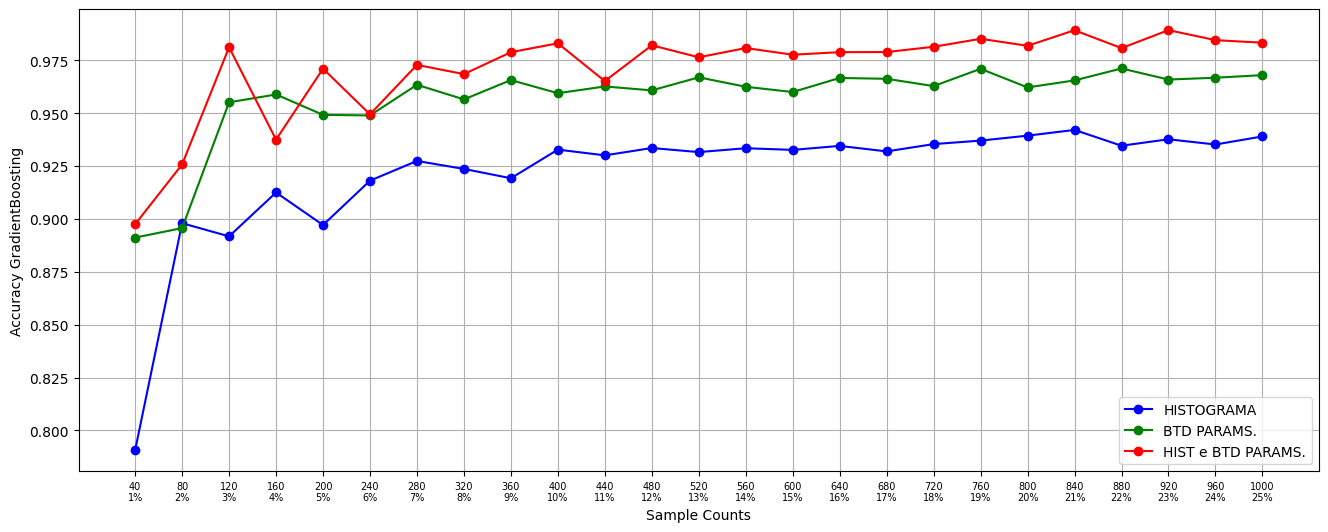

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


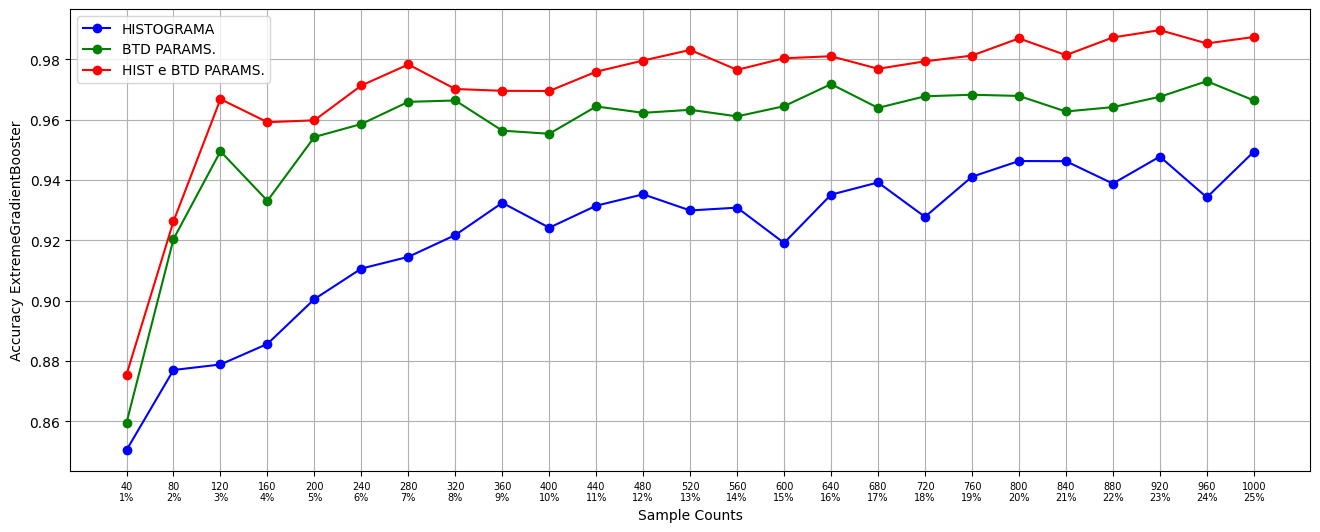

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


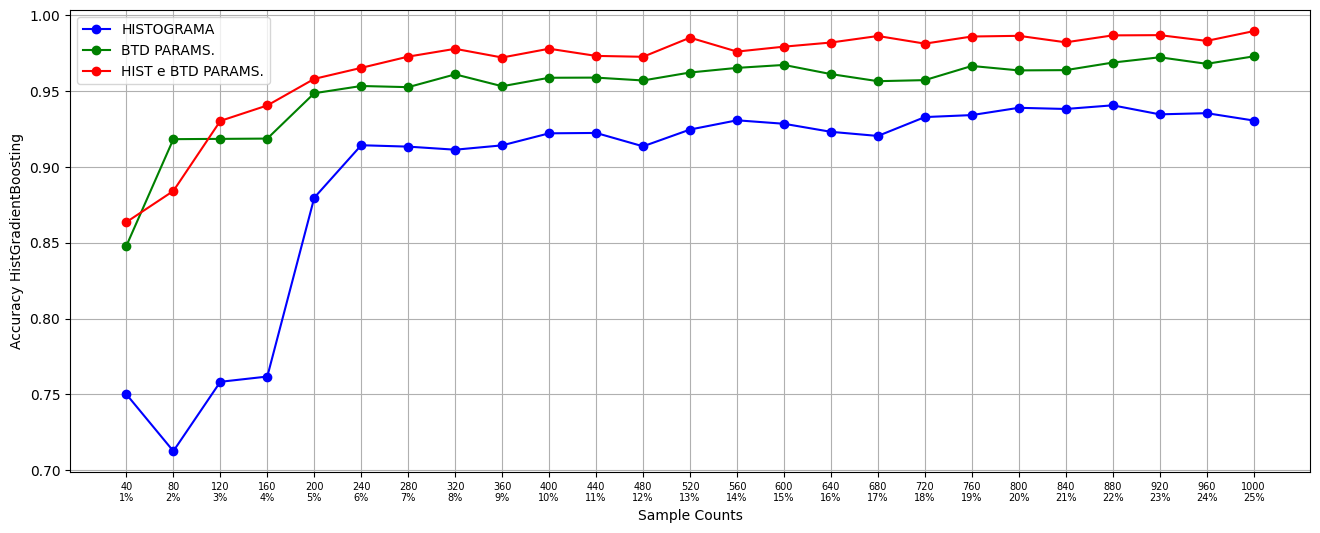

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


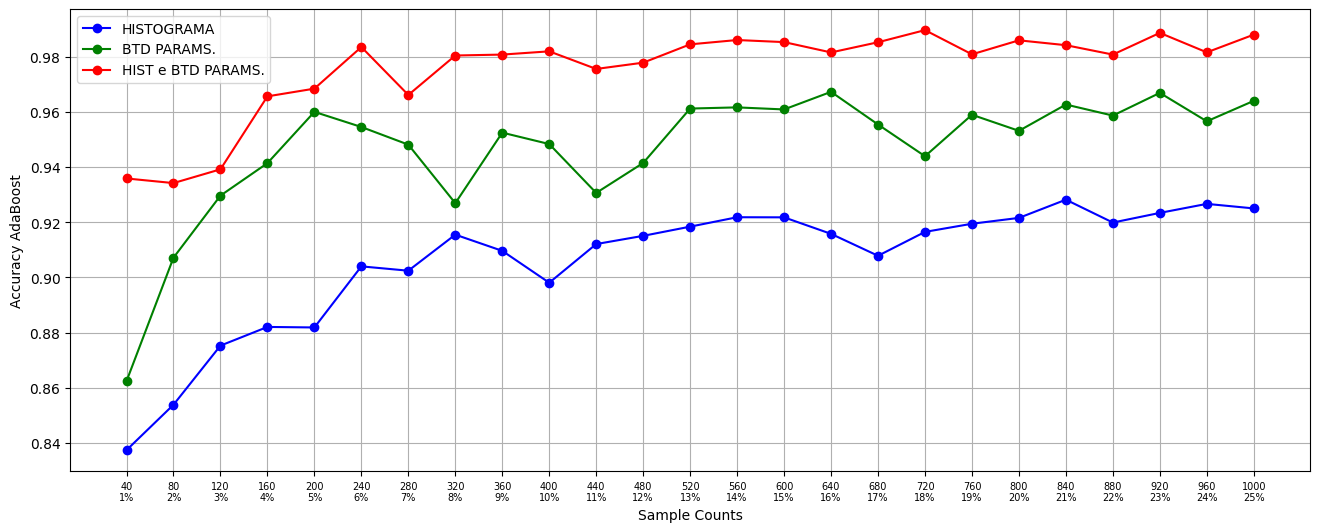

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


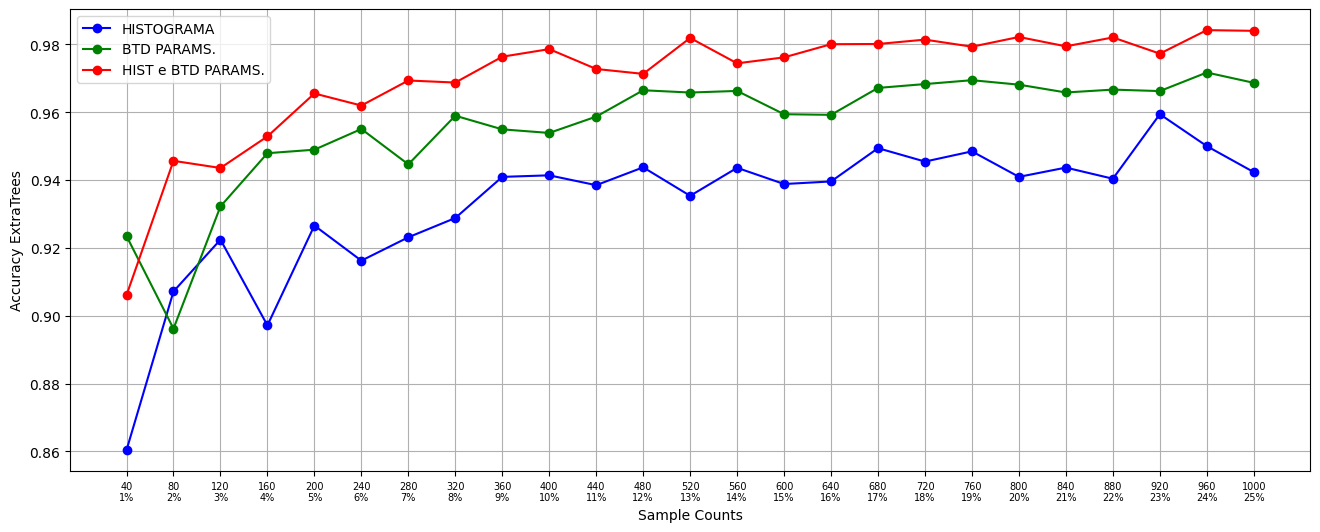

In [9]:
X_experiments = (
    [X_hist, "HISTOGRAMA", "b"],
    [X_btd, "BTD PARAMS.", "g"],
    [X_hist_btd, "HIST e BTD PARAMS.", "r"],
)

sample_counts = []
accuracies = []
labels = []

models = dict()

models["GradientBoosting"] = GradientBoostingClassifier()
models["ExtremeGradientBooster"] = XGBClassifier()
models["HistGradientBoosting"] = HistGradientBoostingClassifier(max_iter=100)
models["AdaBoost"] = AdaBoostClassifier(n_estimators=100)
models["ExtraTrees"] = ExtraTreesClassifier()

for label, model in models.items():
    plt.figure(figsize=(16, 6))
    plt.xlabel("Sample Counts")
    plt.grid(True)
    plt.legend()

    for X_input, X_label, X_color in X_experiments:
        dataset_sample_counts = []
        dataset_accuracies = []
        dataset_labels = []

        data_percentages = np.arange(25, 0, -1) / 100

        for train_data_percentage in data_percentages:
            train_data_percentage = round(train_data_percentage, 4)

            num_samples = int(len(X_input) * train_data_percentage)

            X_train, X_test, y_train, y_test = train_test_split(
                X_input, y, test_size=1 - train_data_percentage
            )

            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)

            dataset_sample_counts.append(num_samples)
            dataset_accuracies.append(accuracy)
            dataset_labels.append(f"{num_samples}\n{train_data_percentage * 100:.0f}%")

        dataset_results_df = pd.DataFrame(
            {"Sample Counts": dataset_sample_counts, "Accuracy": dataset_accuracies}
        )

        plt.xticks(dataset_sample_counts, dataset_labels, fontsize=7)
        
        plt.plot(
            dataset_results_df["Sample Counts"],
            dataset_results_df["Accuracy"],
            marker="o",
            label=X_label,
            color=X_color,
        )
        plt.legend()
        
    plt.ylabel(f"Accuracy {label}")
    plt.show()

In [35]:
gb_clf =ExtraTreesClassifier()

kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(gb_clf, X, y, cv=kf)

print("Cross-validation scores:", scores)

mean_score = np.mean(scores)
std_deviation = np.std(scores)
print(f"Mean accuracy: {mean_score:.2f} (+/- {std_deviation:.2f})")

Cross-validation scores: [0.99514563 0.98543689 0.99029126 0.99514563 0.99029126 0.99029126
 0.99029126 0.98536585 0.99512195 0.9804878 ]
Mean accuracy: 0.99 (+/- 0.00)


# PCA + SVM

In [ ]:
pca = PCA(n_components=4)

svm_classifier = SVC(kernel="linear", C=1)

pipeline = Pipeline([("pca", pca), ("svm", svm_classifier)])

kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(pipeline, X, y, cv=kf)

print("Cross-validation scores:", scores)

mean_score = np.mean(scores)
std_deviation = np.std(scores)
print(f"Mean accuracy: {mean_score:.2f} (+/- {std_deviation:.2f})")

# XGBOOST

In [ ]:
xgb_classifier = XGBClassifier()
kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(xgb_classifier, X_hist_btd, y, cv=kf)

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Calculate and print the mean and standard deviation of the scores
mean_score = np.mean(scores)
std_deviation = np.std(scores)
print(f"Mean accuracy: {mean_score:.2f} (+/- {std_deviation:.2f})")

# MLP qualis

In [ ]:
model1 = MLPClassifier(
    activation="tanh",
    alpha=2.6e-06,
    beta_1=0.999,
    beta_2=0.9,
    hidden_layer_sizes=(50, 50),
    max_iter=64,
    n_iter_no_change=32,
    validation_fraction=0.0,
    warm_start=True,
)


kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(pipeline, X, y, cv=kf)

print("Cross-validation scores:", scores)

mean_score = np.mean(scores)
std_deviation = np.std(scores)
print(f"Mean accuracy: {mean_score:.2f} (+/- {std_deviation:.2f})")

In [ ]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({"Sample Counts": sample_counts, "Accuracy": accuracies})

# Plot the results
plt.figure(figsize=(16, 6))
plt.plot(results_df["Sample Counts"], results_df["Accuracy"], marker="o")

plt.xlabel("Sample Counts")
plt.xticks(sample_counts, labels, fontsize=7)  # Set x-axis labels every fifth sample
plt.ylabel("Accuracy")
plt.grid(True)

# Show the plot
plt.show()